In [1]:
# Uncomment the following line to install the required packages if not already installed
# !pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc qiskit-ibm-transpiler[ai-local-mode]

# Quantum Walks and Monte Carlo

## Part I - Universal Statistical Simulator Understanding

The 2-pager description of the approach to achieve various distributions with Quantum Galton Board can be found here: [solution summary](solution_summary.md).

## Part II - General Algorithm for Quantum Galton Box

In [2]:
from typing import List, Dict, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

from circuit_runner import CircuitRunner, RunMode
from distributions import DistributionGenerator

In [ ]:
SHOTS = 8192
ENABLE_REAL_DEVICE = True

In [4]:
def calculate_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    start, finish = middle - level, middle + level
    return [(i, i + 1) for i in range(start, finish)]


def calculate_fs_wire_tuples(n) -> List[Tuple[int, int]]:
    iterations = math.floor((n + 1) / 2)
    return [(i * 2 + 1, 2 * n + 2 - (i * 2) - 1) for i in range(iterations)]

In [5]:
def create_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, wire_tuples=calculate_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    quantum_coin = QuantumRegister(1, "coin")
    qgb = QuantumRegister(2 * n + 1, "QGB")
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(
        quantum_coin, qgb, distribution, name="Quantum Galton Board"
    )
    levels(circuit)
    measures(circuit)
    return circuit

In [6]:
def hadamard_coin(qc: QuantumCircuit, n: int, level: int):
    """Applies a Hadamard coin operation for the Quantum Galton Board."""
    qc.h(0)

In [7]:
n = 6
dg = DistributionGenerator(n, SHOTS)
runner = CircuitRunner(n, SHOTS, RunMode.NOISELESS_SIMULATOR)

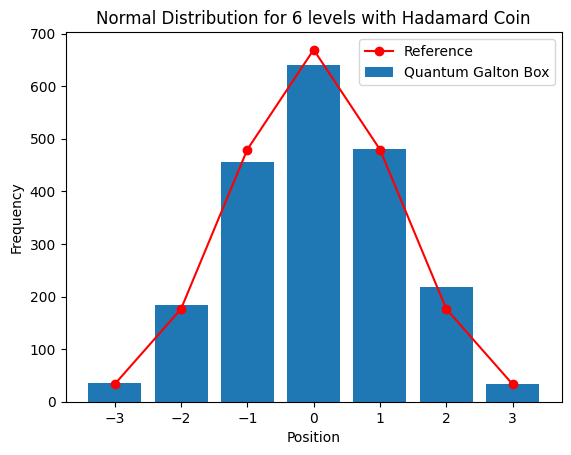

In [8]:
positions, gaussian = dg.normal()
circuit = create_qgb_circuit(n, hadamard_coin)
compiled_circuit = transpile(
    circuit, backend=runner.job_runner, optimization_level=3
)
runner.run_circuit(compiled_circuit)
runner.plot_freqs(
    title=f"Normal Distribution for {n} levels with Hadamard Coin",
    x_map=list(positions),
    reference_values=gaussian,
)

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

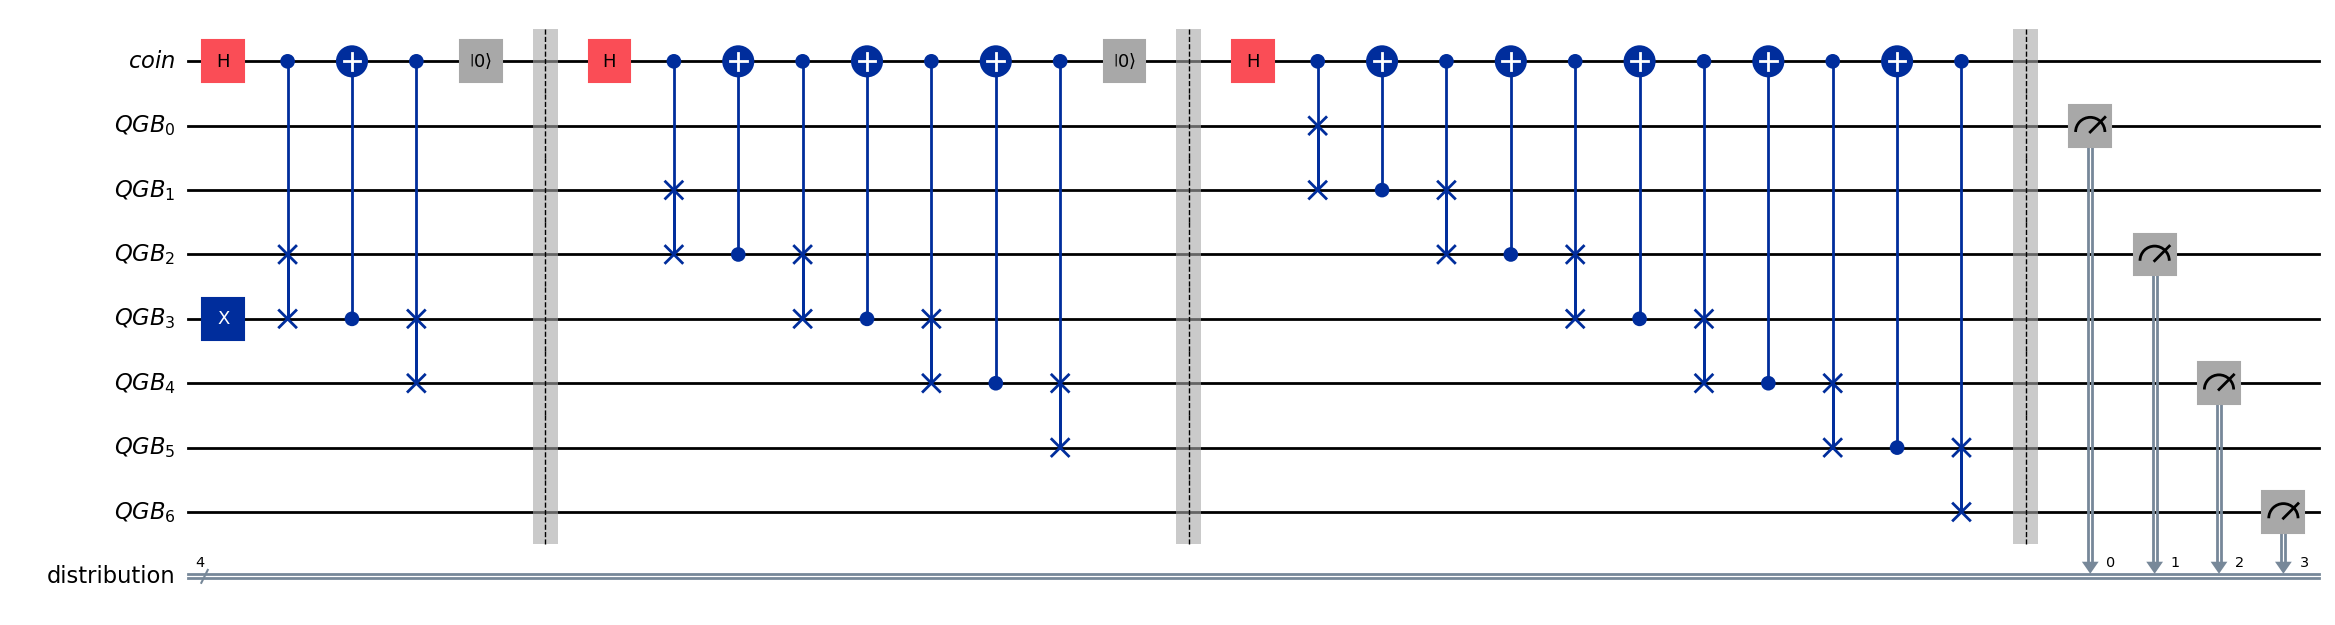

In [9]:
qc = create_qgb_circuit(3, hadamard_coin)
qc.draw("mpl", fold=-1)

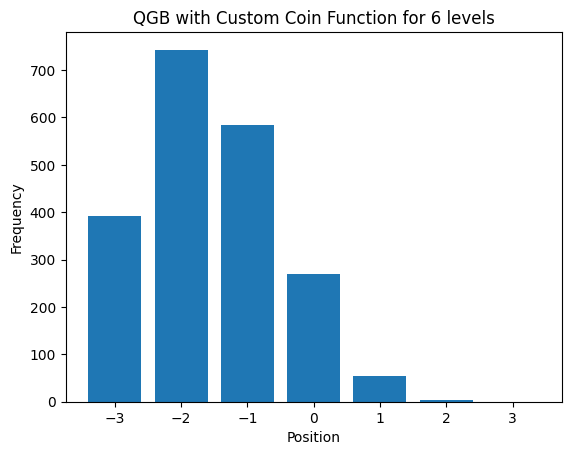

In [10]:
left = -(n / 2)
right = left + n + 1
positions = np.arange(left, right)

coin_function = lambda qc, n, level: qc.ry(2 * np.pi / 3, 0)
circuit = create_qgb_circuit(n, coin_function)
compiled_circuit = transpile(
    circuit, backend=runner.job_runner, optimization_level=3
)
runner.run_circuit(compiled_circuit)
runner.plot_freqs(
    title=f"QGB with Custom Coin Function for {n} levels",
    x_map=list(positions),
)

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [11]:
def exponential_coin(qc: QuantumCircuit, n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qc.ry(theta, 0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qc.cx(i, 0)
        qc.cry(theta, middle + level - 1, 0)

In [12]:
n = 6
dg = DistributionGenerator(n, SHOTS)
runner = CircuitRunner(n, SHOTS, RunMode.NOISELESS_SIMULATOR)

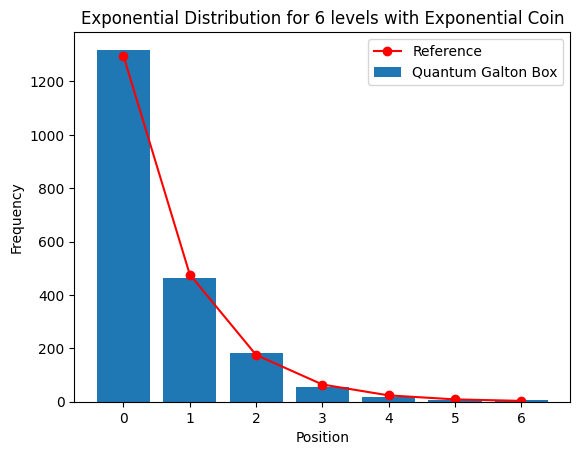

In [13]:
circuit = create_qgb_circuit(n, exponential_coin)
compiled_circuit = transpile(
    circuit, backend=runner.job_runner, optimization_level=3
)
positions, exp_freqs = dg.exponential()

runner.run_circuit(compiled_circuit)
runner.plot_freqs(
    title=f"Exponential Distribution for {n} levels with Exponential Coin",
    x_map=list(positions),
    reference_values=exp_freqs,
)

### Hadamard Quantum Walk

We modify the QGB circuit to simultaneously shift the ball left and right (controlled by the coin state). It removes the need to apply CNOT between the controlled-SWAP operations, but we now have to control it both on 0 and 1 values of the coin.

In [14]:
def calculate_hrw_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i + 1) for i in range(middle - level, middle + level)]


def calculate_hrw_fs_wire_tuples(n) -> List[Tuple[int, int]]:
    iterations = math.floor((n + 1) / 2)
    return [(i * 2 + 1, 2 * n + 2 - (i * 2) - 1) for i in range(iterations)]


def create_hrw_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the n-steps Hadamard Walk distribution
    leveraging the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples):
        control_value = 0
        print(len(wire_tuples))
        for wires in wire_tuples:
            qc.cswap(0, wires[0], wires[1], ctrl_state=control_value)
            control_value ^= 1

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_hrw_wire_tuples(n, level))
            qc.barrier()

    def final_swap(qc: QuantumCircuit):
        qc.reset(0)
        qc.h(0)
        for wires in calculate_hrw_fs_wire_tuples(n):
            qc.cswap(0, wires[0], wires[1])
        qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(2 * n + 2)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    final_swap(circuit)
    measures(circuit)
    return circuit

In [15]:
n = 6
dg = DistributionGenerator(n, SHOTS)
runner = CircuitRunner(n, SHOTS, RunMode.NOISELESS_SIMULATOR)

2
4
6
8
10
12


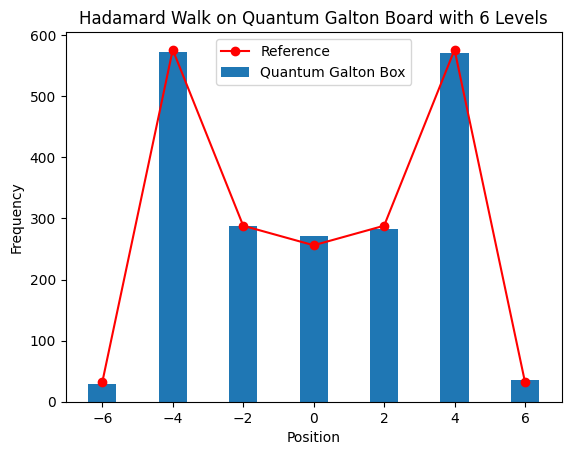

In [16]:
circuit = create_hrw_qgb_circuit(n, hadamard_coin)
compiled_circuit = transpile(
    circuit, backend=runner.job_runner, optimization_level=3
)
positions, reference_hadamard_walk_freqs = dg.hadamard()
runner.run_circuit(compiled_circuit)
runner.plot_freqs(
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels",
    x_map=positions,
    reference_values=reference_hadamard_walk_freqs,
)

2
4
6


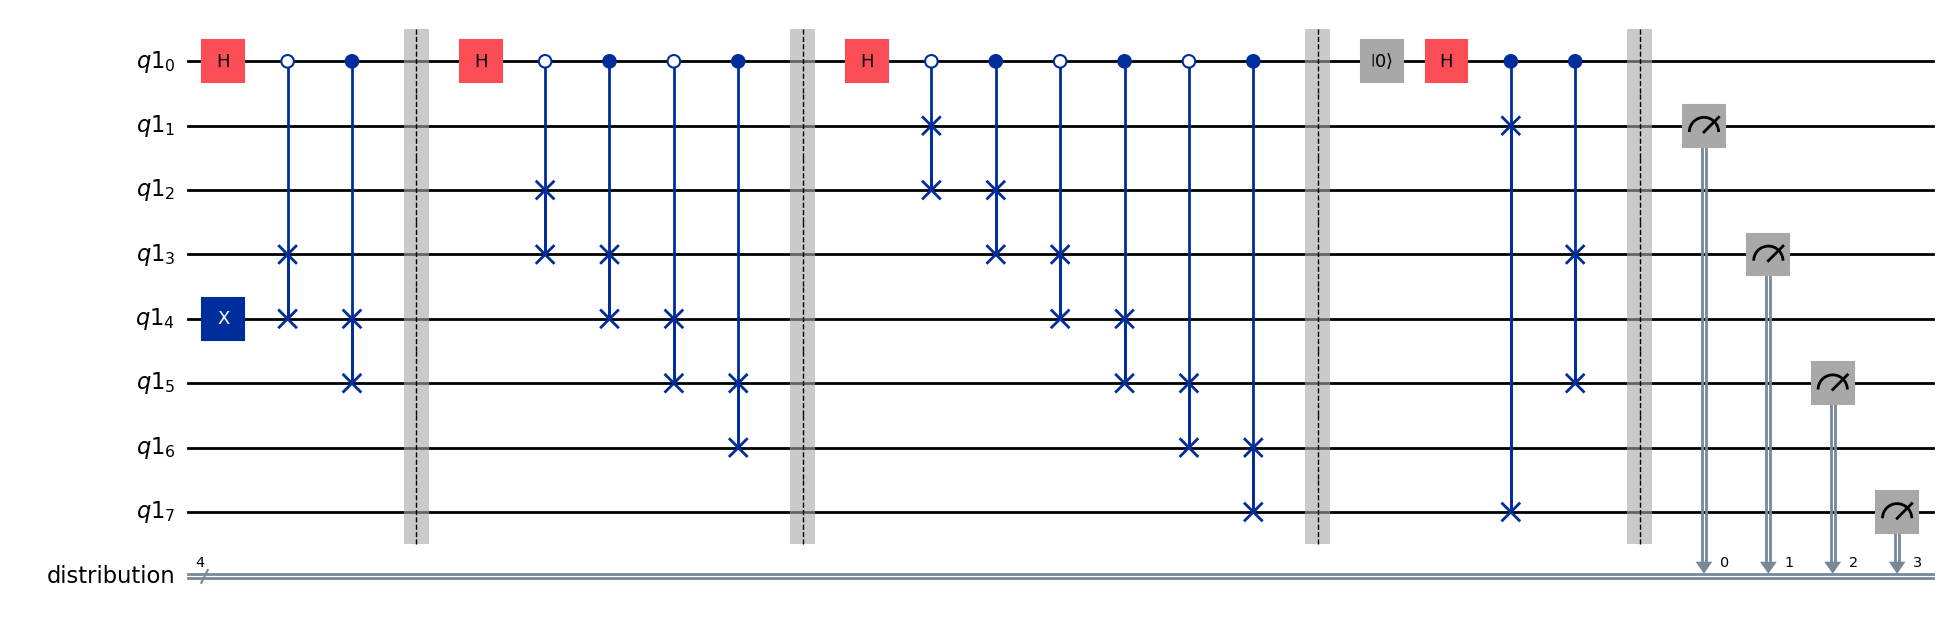

In [17]:
circuit = create_hrw_qgb_circuit(3, hadamard_coin)
circuit.draw("mpl", fold=-1)

## Part IV - Optimization under Noise Models

Having our implementation working on the noiseless simulators, we will now work on exploring the circuit under a noise model.

Pennylane allows loading noise models from Qiskit's IBM backends. We will use this feature to assist in the effort of optimizing the circuits (maximazing the accuracy and number of Galton board layers).

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import PassManager
from qiskit_ibm_transpiler.ai.routing import AIRouting
from qiskit_ibm_transpiler.ai.synthesis import AIPermutationSynthesis
from qiskit_ibm_transpiler.ai.collection import CollectPermutations
from qiskit_ibm_transpiler import generate_ai_pass_manager


service = QiskitRuntimeService()
real_torino = service.backend("ibm_torino")
real_brisbane = service.backend("ibm_brisbane")
print(real_torino.num_qubits, real_brisbane.num_qubits)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-25 14:10:47,985: Default instance not set. Searching all available instances.


133 127


### Exponential Distribution

In [19]:
# Classiq implementation
# repeat(q.len, lambda i: RY(2.0 * atan(exp((-rate * 2.0**i) / 2.0)), q[i]))
def prep_exponential(n, rate) -> QuantumCircuit:
    """Prepare exponential distribution on n qubits."""
    circuit = QuantumCircuit(n, n)
    for i in range(n):
        circuit.ry(2.0 * math.atan(math.exp((-rate * 2.0**i) / 2.0)), i)
    circuit.measure(range(n), range(n))
    return circuit

In [20]:
def optimized_exponential_coin(qc: QuantumCircuit, n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qc.ry(theta, 0)
    else:
        qc.cry(theta, level + 1, 0)

In [21]:
def calculate_exp_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    return [(i, i + 1) for i in range(level, level + 2)]

In [22]:
def create_exp_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(2)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, wire_tuples=calculate_exp_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(list(range(1, n + 1)) + [n + 2]):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(n + 3)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    measures(circuit)
    return circuit

In [23]:
n = 6
dg = DistributionGenerator(n, SHOTS)

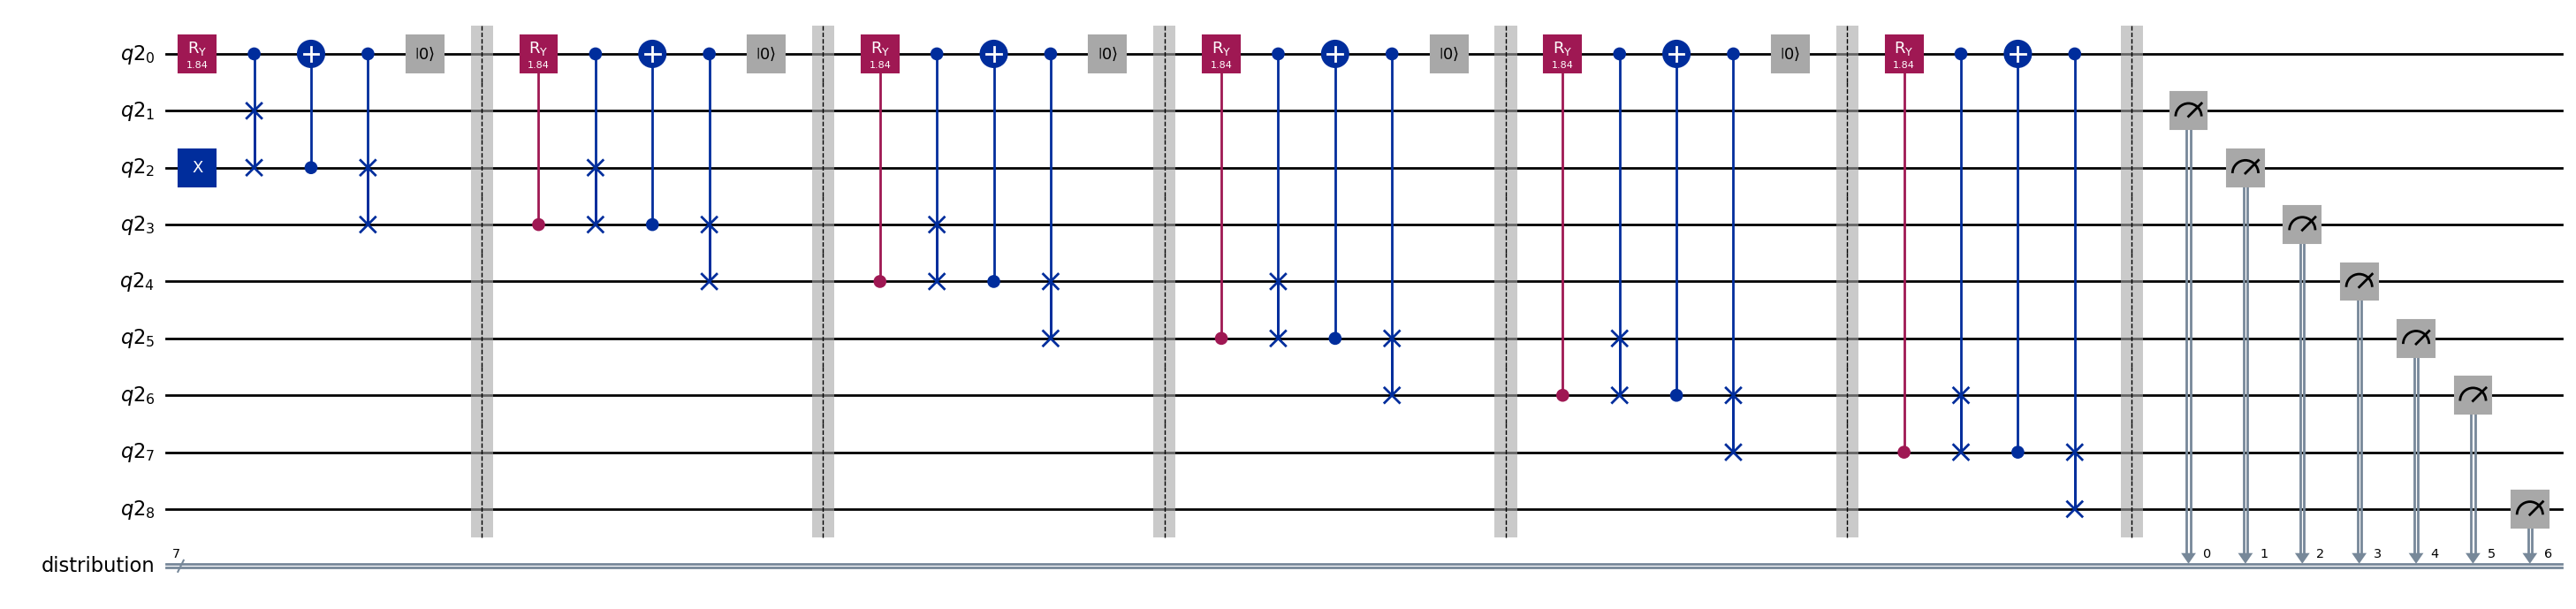

In [24]:

exp_circuit = create_exp_qgb_circuit(n, optimized_exponential_coin)
exp_circuit.draw("mpl", fold=-1)

Without the optimizations, running the circuit under the noise model will produce inaccurate results as shown below.

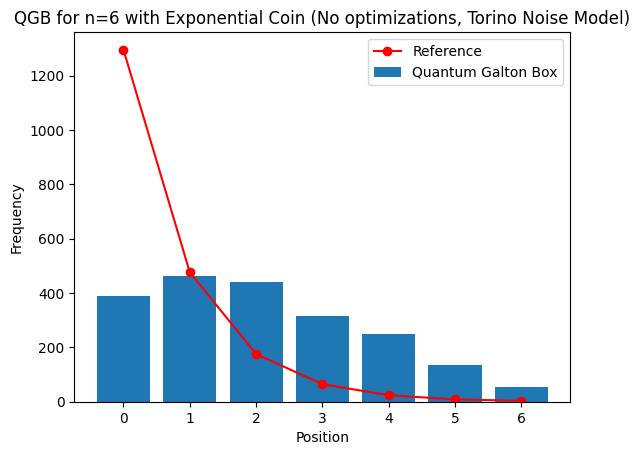

In [25]:
runner = CircuitRunner(n, SHOTS, RunMode.NOISY_SIMULATOR, backend=real_torino)
positions, reference_exp_freqs = dg.exponential()
circuit = create_qgb_circuit(n, exponential_coin)
compiled_circuit = transpile(
    circuit, backend=runner.job_runner, optimization_level=3
)
runner.run_circuit(compiled_circuit)
runner.plot_freqs(
    title=f"QGB for n={n} with Exponential Coin (No optimizations, Torino Noise Model)",
    x_map=list(positions),
    reference_values=reference_exp_freqs,
)

Even though we can recognize the diminishing amplitudes starting from the position 2, they are far from matching the reference exponential distribution line.

Now, with the suggested optimizations for the exponential distribution on Quantum Galton Board, the results will improve significantly.

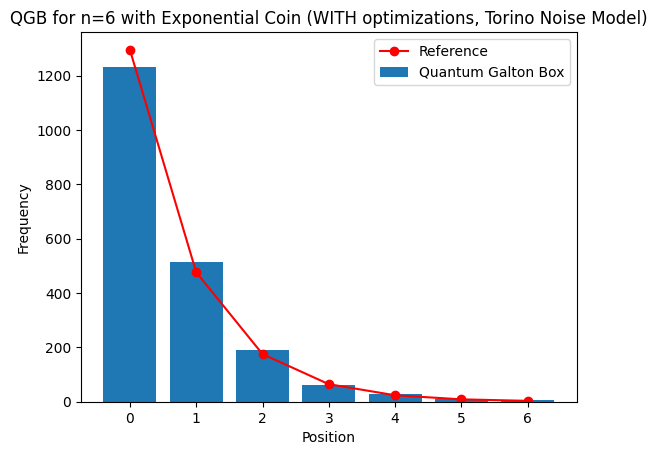

In [26]:
runner = CircuitRunner(n, SHOTS, RunMode.NOISY_SIMULATOR, backend=real_torino)
positions, reference_exp_freqs = dg.exponential()

# here we use the modified circuit with less qubits and an optimized coin.
circuit = create_exp_qgb_circuit(n, optimized_exponential_coin)
compiled_circuit = transpile(
    circuit, backend=runner.job_runner, optimization_level=3
)
runner.run_circuit(compiled_circuit)
runner.plot_freqs(
    title=f"QGB for n={n} with Exponential Coin (WITH optimizations, Torino Noise Model)",
    x_map=list(positions),
    reference_values=reference_exp_freqs,
)

If you set `ENABLE_REAL_DEVICE = True`, the following cell will run on the real IBM quantum device. In our case, we are choosing `ibm_torino` (same device we used to model the noise).

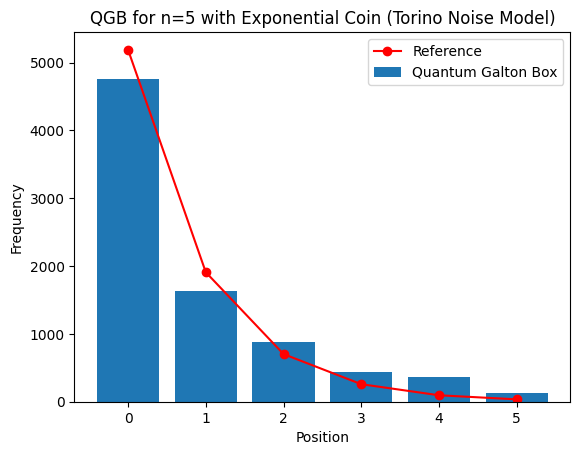

In [ ]:
if ENABLE_REAL_DEVICE:
    positions, reference_exp_freqs = DistributionGenerator(n, SHOTS).exponential()
    runner = CircuitRunner(n, SHOTS, RunMode.REAL_DEVICE, backend=real_torino)
    circuit = create_exp_qgb_circuit(n, optimized_exponential_coin)
    compiled_circuit = transpile(
        circuit, backend=real_torino, optimization_level=3
    )
    runner.run_circuit(compiled_circuit)
    runner.plot_freqs(
        title=f"QGB for n={n} with Exponential Coin (Torino Noise Model)",
        x_map=list(positions),
        reference_values=reference_exp_freqs,
    )

## Part V - Study the Distances between Obtained and Target Distributions

Let's now turn to understanding how well the obtained distributions are approximating the target distributions.

We have collected a hefty amount of samples for both Exponential and Hadamard Random Walk circuits executed under the noise model.

In [ ]:
freqs = {
    "000000": 173,
    "111000": 9,
    "000010": 190,
    "000111": 49,
    "001010": 106,
    "111011": 4,
    "011110": 33,
    "001000": 95,
    "100110": 17,
    "000110": 183,
    "000100": 154,
    "000001": 69,
    "001100": 77,
    "001111": 40,
    "011010": 39,
    "010000": 37,
    "000011": 72,
    "100001": 8,
    "001001": 25,
    "101100": 6,
    "001110": 97,
    "000101": 37,
    "011001": 10,
    "001011": 37,
    "010010": 39,
    "111100": 4,
    "001101": 28,
    "011000": 37,
    "110010": 10,
    "011101": 18,
    "110110": 7,
    "010100": 40,
    "010101": 11,
    "010001": 9,
    "010110": 33,
    "110011": 5,
    "101101": 4,
    "100010": 15,
    "111001": 4,
    "101000": 10,
    "111101": 1,
    "110001": 3,
    "010111": 16,
    "100000": 19,
    "110000": 11,
    "011100": 26,
    "100100": 15,
    "101010": 12,
    "100111": 4,
    "011111": 4,
    "100011": 10,
    "011011": 12,
    "101110": 15,
    "110111": 5,
    "111111": 2,
    "110100": 9,
    "111010": 5,
    "101111": 8,
    "010011": 18,
    "101011": 2,
    "111110": 2,
    "100101": 3,
    "101001": 4,
    "110101": 1,
}

In [ ]:
n = 5


def get_ones_indices(s: str) -> List[int]:
    """Returns the indices of '1's in the bitstring."""
    return [i for i, c in enumerate(s) if c == "1"]


new_freqs = {f"{2**i:0{n+1}b}": 0 for i in range(n + 1)}
for bitstring, count in freqs.items():
    indices = get_ones_indices(bitstring)
    if len(indices) == 0:
        indices = list(range(n + 1))  # If no '1's, consider all indices
    fraction = count / len(indices)
    for i in indices:
        new_freqs[f"{2**(n-i):0{n+1}b}"] += fraction
total_counts = sum(new_freqs.values())
if total_counts < SHOTS:
    ratio = SHOTS / total_counts
    for key in new_freqs:
        new_freqs[key] = int(new_freqs[key] * ratio)
print(new_freqs)

In [ ]:
plt.bar(new_freqs.keys(), new_freqs.values(), label="Quantum Galton Box")

#### Gaussian on noisy simulator

In [ ]:
n = 8
qc = create_qgb_circuit(n, hadamard_coin, correction=0)
# simulator = AerSimulator()
# simulator = AerSimulator(method='statevector')
simulator = AerSimulator.from_backend(real_torino)

compiled_circuit = transpile(qc, simulator, optimization_level=3)
ai_transpiler_pass_manager = generate_ai_pass_manager(
    backend=simulator,
    ai_optimization_level=3,
    optimization_level=3,
    ai_layout_mode="optimize",
)
# compiled_circuit = ai_transpiler_pass_manager.run(compiled_circuit)
job = simulator.run([compiled_circuit], shots=SHOTS)  # Execute the circuit
result = job.result()

freqs = result.get_counts()
for i in range(0, n + 1):
    bits = ["0"] * (n + 1)
    bits[i] = "1"
    bitstring = "".join(bits)
    if bitstring not in freqs:
        freqs[bitstring] = 0
freqs = cleanup_freqs(dict(sorted(freqs.items())), n, SHOTS)
positions, gaussian = create_gaussian(n, SHOTS)
plot_freqs(
    n,
    freqs,
    title=f"Histogram of Frequencies for n={n} with Hadamard Coin",
    x_map=list(positions),
    reference_values=gaussian,
)

#### Exponential on noisy simulator

In [ ]:
n = 16
qc = create_exp_qgb_circuit(n, optimized_exponential_coin)

# simulator = AerSimulator(method="statevector")
simulator = AerSimulator.from_backend(real_torino)

compiled_circuit = transpile(qc, simulator, optimization_level=3)
ai_transpiler_pass_manager = generate_ai_pass_manager(
    backend=simulator,
    ai_optimization_level=3,
    optimization_level=3,
    ai_layout_mode="optimize",
)
compiled_circuit = ai_transpiler_pass_manager.run(compiled_circuit)
job = simulator.run([compiled_circuit], shots=SHOTS)  # Execute the circuit
result = job.result()

freqs = result.get_counts()
for i in range(0, n + 1):
    bits = ["0"] * (n + 1)
    bits[i] = "1"
    bitstring = "".join(bits)
    if bitstring not in freqs:
        freqs[bitstring] = 0
freqs = cleanup_freqs(dict(sorted(freqs.items())), n, SHOTS)
x = np.arange(0, n + 1)
lambda_rate = 1
reference_freqs = np.exp(-lambda_rate * x)
reference_freqs /= reference_freqs.sum()
reference_freqs *= SHOTS
plot_freqs(n, freqs, x_map=x, reference_values=reference_freqs)

#### Hadamard Random Walk on noisy simulator

In [ ]:
n = 2
qc = create_hrw_qgb_circuit(n, hadamard_coin)

simulator = AerSimulator()
# simulator = AerSimulator.from_backend(real_torino)

compiled_circuit = transpile(qc, backend=simulator, optimization_level=3)
# ai_passmanager = PassManager(
#     [
#         AIRouting(
#             backend=real_torino,
#             optimization_level=3,
#             layout_mode="optimize",
#             local_mode=True,
#         ),  # Route circuit
#         CollectPermutations(),  # Collect Permutation blocks
#         AIPermutationSynthesis(
#             backend=real_torino, local_mode=True
#         ),  # Re-synthesize Permutation blocks
#     ]
# )
# ai_transpiler_pass_manager = generate_ai_pass_manager(
#    backend=simulator,
#     ai_optimization_level=3,
#     optimization_level=3,
#     ai_layout_mode="optimize",
# )
# compiled_circuit = ai_transpiler_pass_manager.run(compiled_circuit)
job = simulator.run([circuit], shots=SHOTS)  # Execute the circuit
result = job.result()

freqs = result.get_counts()
for i in range(0, n + 1):
    bits = ["0"] * (n + 1)
    bits[i] = "1"
    bitstring = "".join(bits)
    if bitstring not in freqs:
        freqs[bitstring] = 0
freqs = dict(sorted(freqs.items())), n, SHOTS

plt.bar(freqs[0].keys(), freqs[0].values(), label="Quantum Galton Board Hadamard Walk")

In [ ]:
def uniform_distribution_coin(qc: QuantumCircuit, n, level):
    """Applies an appropriate coin rotation based on the level."""
    if level % 2 == 1:
        p = 0.5
    else:
        p = 2 / (n + 3 - level)
    theta = 2 * math.acos(np.sqrt(p))
    opp_theta = 2 * math.asin(np.sqrt(p))
    if level == 1:
        qc.ry(theta, 0)
    else:
        middle = n + 1
        if level % 2 == 1:
            for i in range(middle - level + 1, middle):
                qc.cx(i, 0)
            qc.cry(theta, middle, 0)
        else:
            for i in range(middle - level + 1, middle - 1):
                qc.cx(i, 0)
            qc.cry(theta, middle + 1, 0)
            qc.cry(opp_theta, middle - 1, 0)

In [ ]:
def create_uniform_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, wire_tuples=calculate_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    quantum_coin = QuantumRegister(1, "coin")
    qgb = QuantumRegister(2 * n + 1, "QGB")
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(
        quantum_coin, qgb, distribution, name="Quantum Galton Board"
    )
    levels(circuit)
    measures(circuit)
    return circuit

In [ ]:
n = 5
qc = create_uniform_qgb_circuit(n, uniform_distribution_coin)
# simulator = AerSimulator()
# simulator = AerSimulator(method='statevector')
simulator = AerSimulator.from_backend(real_torino)

compiled_circuit = transpile(qc, simulator, optimization_level=3)
job = simulator.run([compiled_circuit], shots=SHOTS)  # Execute the circuit
result = job.result()

freqs = result.get_counts()
for i in range(0, n + 1):
    bits = ["0"] * (n + 1)
    bits[i] = "1"
    bitstring = "".join(bits)
    if bitstring not in freqs:
        freqs[bitstring] = 0
freqs = cleanup_freqs(dict(sorted(freqs.items())), n, SHOTS)
positions = list(range(n + 1))
uniform = np.array([1 / (n + 1)] * (n + 1)) * SHOTS
plot_freqs(
    n,
    freqs,
    title=f"Histogram of Frequencies for n={n} with Uniform Distribution Coin",
    x_map=list(positions),
    reference_values=uniform,
)

In [ ]:
qc.draw("mpl", fold=-1)

In [ ]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library import efficient_su2
from qiskit_ibm_transpiler.ai.routing import AIRouting
from qiskit_ibm_runtime import QiskitRuntimeService

backend = QiskitRuntimeService().backend("ibm_torino")
ai_passmanager = PassManager(
    [
        AIRouting(
            backend=backend,
            optimization_level=2,
            layout_mode="optimize",
            local_mode=True,
        )
    ]
)


circuit = efficient_su2(101, entanglement="circular", reps=1)

transpiled_circuit = ai_passmanager.run(circuit)